In [1]:
import numpy as np
import os
import pandas as pd
import torch
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim

import config
from model import YOLOv3
from dataset import LbpDataset, train_transforms, val_transforms
# from dataset import LbpDataset
from train import  train_fn
from scheduler import CosineAnnealingWarmUpRestarts

from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
from visualize import visualize

In [2]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

In [3]:
df = pd.read_csv('../data/df.csv')
df['label_id'] = df.label.apply( lambda x : 0.)
df_data = df.groupby('path')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = df_data.get_group(img_id)
#     boxes = data['bbox'].values
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
#     labels = data['label'].values
    return dict(image_id = img_id, boxes = boxes)
#     return dict(image_id = img_id, boxes = boxes, labels=labels)

image_list = [get_data(img_id) for img_id in df.path.unique()]
# df.head()
image_list[0]

{'image_id': 'patch_images/2021.01.08/LBC141-20210105(1)/LBC141-20210105(1)_1001.png',
 'boxes': array([[1558., 1603.,   96.,   73.,    0.],
        [1452., 1263.,   82.,   94.,    0.]])}

In [4]:
IMAGE_SIZE = config.IMAGE_SIZE
train_dataset = LbpDataset(
    image_list,
    transform=train_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    anchors=config.ANCHORS,
)
train_loader = DataLoader(
    dataset=train_dataset,
#     batch_size=config.BATCH_SIZE,
#     num_workers=config.NUM_WORKERS,
    batch_size=1,
    num_workers=1,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [5]:
images, targets = (next(iter(train_dataset)))
# print(len(images))
images.shape

torch.Size([3, 416, 416])

In [9]:
# images.view(416,416,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[326.2272, 333.0080,   9.7344,   7.4048,   0.0000],
        [303.2640, 266.0736,   8.3200,   9.5264,   0.0000]],
       dtype=torch.float64)
(416, 416, 3)


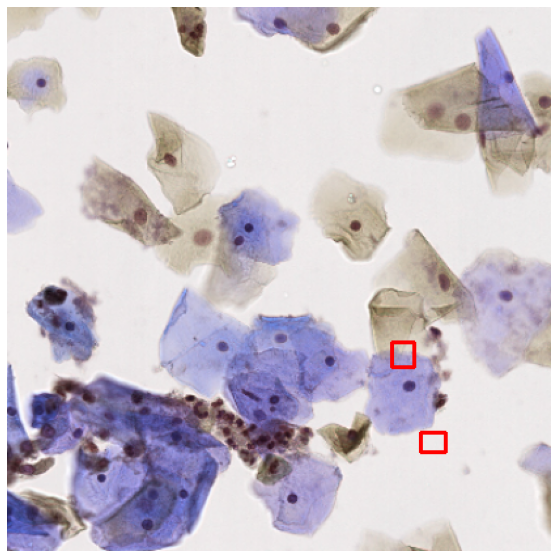

In [7]:
# img = cv2.imread()
bbox = torch.tensor([[0.7842, 0.8005, 0.0234, 0.0178, 0.0000],
        [0.7290, 0.6396, 0.0200, 0.0229, 0.0000]], dtype=torch.float64)*416
print(bbox)
# visualize(images, bbox[:,:4])
visualize(images.permute(1,2,0).numpy(), bbox[:,:4])
# %matplotlib inline
# plt.imshow(images)